- [x] Noisy Dataset
- [x] Normalized Cross Entropy Loss
- [x] Normalized Focal Loss
- [x] Focal Loss
- [x] Normalized Mean Absolute Error Loss
- [x] Normalized Reversed Cross Entropy Loss
- [x] Reversed Cross Entropy Loss
- [x] Loggers
- [x] Comprehensive Model & Metric Storage
- [ ] Model & Metric Retrieval
- [x] APL Framework

## Import Block

In [63]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10


import random
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from LogTracker import IntegerTracker

import copy
import math
import time 

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(24)
LOWER, UPPER = 0.2, 0.8
LOSS_TYPES = ['NCE', 'NFL', 'FL', 'NMAEL', 'NRCEL', 'RCEL', 'APL', 'CE']
torch.cuda.set_per_process_memory_fraction(0.5, device=0)
f"{DEVICE=}, {torch.__version__=}"

"DEVICE='cuda', torch.__version__='2.6.0+cu118'"

___
# **Architecture:**
---

## Transforms

In [64]:
transform_v1 = transforms.Compose([ ### VER 1
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_v2 = transforms.Compose([ ###VER 2
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.2)
])

transform_v3 = transforms.Compose([ ###VER 3
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform = transforms.Compose([ ###VER 4
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
    

In [65]:
# img, lab = train_dataset[1]
# img= img.numpy().transpose((1, 2, 0))
# plt.imshow(img)
# plt.title(lab)
# img.shape

In [66]:
# def NoiseLabels(dataset : CIFAR10, lower=LOWER, upper=UPPER, noise_rate=None):
#     if noise_rate == None:
#         noise_rate = random.uniform(lower, upper)
    
#     targets = np.array(dataset.targets)
#     n_samples = len(targets)
    
#     noise_bools = np.random.rand(n_samples) < noise_rate
#     true_vals = np.sum(noise_bools)

#     #
#     print(f"Mask Info...\n\tExpected Noise Rate: {noise_rate:.3f} | Actual Noise Rate: {true_vals/len(noise_bools) : .3f} | Samples : {(len(noise_bools))}")

#     for i in range(len(noise_bools)):
#         if not noise_bools[i]:
#             continue

#         original_label = targets[i]

#         def RandomLabel():
#             random_label = np.random.choice(targets)
#             return random_label if random_label != original_label else RandomLabel()
#         new_label = RandomLabel()
#         targets[i] = new_label
#     dataset.targets = targets.tolist()
#     return dataset


## Noisy Dataset - Inherited Class

In [67]:
class NoisyDataset(CIFAR10):
    def __init__(self, root='data', transform=None, train=True, download=True, lower=LOWER, upper=UPPER, noise_rate=None):
            
        super().__init__(root=root, train=train, transform=transform, download=download)
        self.noise_rate = 0.2 + (0.8 - 0.2) * torch.rand(1).item() if noise_rate == None else noise_rate
        # print(f"Randomly chosen noise rate: {self.noise_rate}")
        # self.classes = len(self.classes)
        self.__Corrupt()

    def __Corrupt(self):
        targets = torch.tensor(self.targets)
        n_samples = targets.size(0)
        noise_bools = torch.rand(n_samples) < self.noise_rate
        
        true_vals = noise_bools.sum().item()
        print(f"Mask Info...\n\tExpected Noise Rate: {self.noise_rate:.3f} | Actual Noise Rate: {true_vals/len(noise_bools) : .3f} | True/False : {true_vals/(len(noise_bools) - true_vals) :.3f}")
        
        for i in range(len(noise_bools)):
            if not noise_bools[i]:
                continue
                
            original_label = targets[i]
            new_label = self.__ChooseRandomLabel(original_label, targets)
            targets[i] = new_label
            
        self.targets = targets.tolist()

    @staticmethod
    def __ChooseRandomLabel(original_label, targets):
        possible_labels = list(range(num_classes))
        possible_labels.remove(original_label)
        new_label = possible_labels[torch.randint(0, len(possible_labels), (1,)).item()]
        return new_label


## Normalized Cross Entropy - V1

In [ ]:
class NormalizedCrossEntropyLoss_v1(nn.Module):
    def __init__(self, reduction='mean'):
        super(NormalizedCrossEntropyLoss_v1, self).__init__()
        self.reduction = reduction
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        # Compute standard cross-entropy loss
        ce_loss = self.cross_entropy(logits, targets)
        
        # Compute the entropy of the target distribution
        target_probs = torch.softmax(logits, dim=-1)
        entropy = -torch.sum(target_probs * torch.log(target_probs + 1e-12), dim=-1)

        # Normalize the cross-entropy loss by entropy
        normalized_loss = ce_loss / (entropy + 1e-12)

        if self.reduction == 'mean':
            return normalized_loss.mean()
        elif self.reduction == 'sum':
            return normalized_loss.sum()
        else:
            return normalized_loss

## Normalized Cross Entropy - V2 REVISED

In [ ]:
class NormalizedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(NormalizedCrossEntropyLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        # Compute standard cross-entropy loss
        ce_loss = self.cross_entropy(logits, targets)
        
        # Compute the entropy of the target distribution
        target_probs = torch.softmax(logits, dim=-1)
        entropy = -torch.sum(target_probs * torch.log(target_probs + 1e-12), dim=-1)

        # Normalize the cross-entropy loss by entropy
        normalized_loss = ce_loss / (entropy + 1e-12)


        if torch.isnan(normalized_loss).any():
                print("NaN detected!")
                print("Logits:", logits)
                print("Target probs:", target_probs)
                print("Entropy:", entropy)
                print("CE loss:", ce_loss)



        return normalized_loss.mean()  # Scalar
        



## Normalized Cross Entropy - V3

In [ ]:
class NormalizedCrossEntropyLoss_v3(nn.Module):
    def __init__(self, reduction='sum'):
        super(NormalizedCrossEntropyLoss_v3, self).__init__()
        self.reduction = reduction
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        ce_loss = self.cross_entropy(logits, targets)

        log_probs = torch.log_softmax(logits, dim=-1)
        probs = torch.softmax(logits, dim=-1)
        entropy = -torch.sum(probs * log_probs, dim=-1)
        entropy = torch.clamp(entropy, min=1e-6)

        normalized_loss = ce_loss / entropy

        if torch.isnan(normalized_loss).any():
            print("NaN detected!")
            print("Logits:", logits)
            print("Target probs:", log_probs)
            print("Entropy:", entropy)
            print("CE loss:", ce_loss)


        if self.reduction == 'mean':
            return normalized_loss.mean()
        elif self.reduction == 'sum':
            return normalized_loss.sum()
        else:
            return normalized_loss


## Normalized Focal Loss

In [ ]:
class NormalizedFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, epsilon=1e-12):
        super(NormalizedFocalLoss, self).__init__()
        self.gamma = gamma
        self.epsilon = epsilon

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=-1)
        log_probs = F.log_softmax(logits, dim=-1)

        targets_one_hot = F.one_hot(targets, num_classes=logits.shape[-1])
        pt = (probs * targets_one_hot).sum(dim=-1)
        focal_term = (1 - pt).pow(self.gamma)
        loss = -focal_term * log_probs.gather(dim=-1, index=targets.unsqueeze(-1)).squeeze(-1)

        entropy = -torch.sum(probs * log_probs, dim=-1)
        loss /= (entropy + self.epsilon)

        return loss.mean()

## Focal Loss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=-1)
        probs = torch.exp(log_probs)

        targets_one_hot = F.one_hot(targets, num_classes=logits.shape[-1])

        pt = (probs * targets_one_hot).sum(dim=-1)

        focal_term = (1 - pt).pow(self.gamma)
        loss = -focal_term * log_probs.gather(dim=-1, index=targets.unsqueeze(-1)).squeeze(-1)


        return loss.mean()

## Normalized MAE Loss

In [ ]:
class NormalizedMAE(nn.Module):
    def __init__(self, reduction='sum', epsilon=1e-12):
        super(NormalizedMAE, self).__init__()
        self.reduction = reduction
        self.epsilon = epsilon
        self.mae_loss = nn.L1Loss(reduction='none')

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=-1)


        targets_one_hot = F.one_hot(targets, num_classes=logits.shape[-1]).float()

        mae = self.mae_loss(probs, targets_one_hot).sum(dim=-1)

        entropy = -torch.sum(probs * torch.log(probs + self.epsilon), dim=-1)
        normalized_mae = mae / (entropy + self.epsilon)

        return normalized_mae.mean()

## Normalized Reversed Cross Entropy Loss

In [ ]:
class NormalizedReversedCrossEntropyLoss(nn.Module):
    def __init__(self, epsilon=1e-12):
        super(NormalizedReversedCrossEntropyLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=-1)

        targets_one_hot = F.one_hot(targets, num_classes=logits.shape[-1]).float()
        rce_loss = -torch.sum(targets_one_hot * torch.log(probs + self.epsilon), dim=-1)
        entropy = -torch.sum(probs * torch.log(probs + self.epsilon), dim=-1)

        normalized_loss = rce_loss / (entropy + self.epsilon)

        return normalized_loss.mean()

## Reversed Cross Entropy Loss

In [ ]:
class ReversedCrossEntropyLoss(nn.Module):
    def __init__(self, epsilon=1e-12):
        super(ReversedCrossEntropyLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=-1)
        targets_one_hot = F.one_hot(targets, num_classes=logits.shape[-1]).float()
        rce_loss = -torch.sum(targets_one_hot * torch.log(probs + self.epsilon), dim=-1)

        return rce_loss.mean()

In [ ]:
def show_images_with_labels(data_loader, class_names, num_images=16):
    images, labels = next(iter(data_loader))
    
    grid_size = int(np.sqrt(num_images))
    assert grid_size ** 2 == num_images, "num_images must be a perfect square."
    
    images = images.permute(0, 2, 3, 1).numpy()  # Convert to (batch_size, height, width, channels)
    images = (images * 0.5) + 0.5  # Assuming images were normalized to [-1, 1]
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    fig.suptitle("Images and Labels", fontsize=16)
    
    for i, ax in enumerate(axes.flatten()):
        if i >= num_images:
            break
        ax.imshow(images[i])
        ax.axis("off") 
        ax.set_title(class_names[labels[i].item()], fontsize=10, color="black")
    
    plt.tight_layout()
    plt.show()


# show_images_with_labels(train_data_loader, classes, num_images=16)

## Model - V1

In [76]:

class CNN_V1(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units=128):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces 32x32 -> 16x16
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 2, out_channels=hidden_units * 2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces 16x16 -> 8x8
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units * 2, out_channels=hidden_units * 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 4, out_channels=hidden_units * 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces 8x8 -> 4x4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 4 * 4 * 4, out_features=256),  # Flattened size: 4x4x(hidden_units * 4)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=256, out_features=output_shape)  # Output size: number of classes
        )

    def forward(self, x, print_dims=False):
        y_b1 = self.block1(x)
        y_b2 = self.block2(y_b1)
        y_b3 = self.block3(y_b2)
        y = self.classifier(y_b3)
        if print_dims:
            print(f"{y_b1.shape=}")
            print(f"{y_b2.shape=}")
            print(f"{y_b3.shape=}")
            print(f"{y.shape=}")
        return y

## Model - V2

In [77]:
class CNN_V2(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_V2, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

## Model - V3

In [78]:
class CNN_V3(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_V3, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LayerNorm([32, 32, 32]),  # LayerNorm instead of BatchNorm
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.LayerNorm([32, 32, 32]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LayerNorm([64, 16, 16]),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LayerNorm([64, 16, 16]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LayerNorm([128, 8, 8]),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.LayerNorm([128, 8, 8]),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


## Model - V4

In [79]:
class CNN_V4(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_V4, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=32),  # GroupNorm instead of LayerNorm
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


## Model - V3

In [80]:
class CNN9Layer(nn.Module):
    def __init__(self, num_classes=10, dropout_p=0.5):
        super(CNN9Layer, self).__init__()
        
        # 3 convolutional blocks
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # CIFAR-10 images are 32x32
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Termination flag checker, Logger, and Retriever for remote logger

In [114]:
def check_termination_flag(file_path="TFlag.txt"):
    try:
        with open(file_path, 'r') as file:
            content = file.read().strip()
            if content == '0':
                print("Received Termination Signal. Terminating...")
                return True
            elif content == '1':
                return False
            else:
                print(f"Unexpected content in file: {content}. Expected '0' or '1'. Terminating Process...")
                return True
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return False
    except Exception as e:
        print(f"Error reading {e}. Terminating Process...")
        return True

def log(message, loss_type, version):
    if loss_type not in LOSS_TYPES:
        print("Invalid loss type! Terminating Logger...")
        
    
    path = f"{loss_type}\\Logs\\Log_{version}.txt"
    with open(path, "a") as f:
        f.write(f"{time.strftime('%H:%M:%S')} - {message}\n")
# def load_saved_data(PATH):
#     """
#     Loads the saved model, optimizer, criterion, scheduler, and metrics from the specified PATH.

#     :param PATH: Path to the saved file.
#     """
#     loaded_data = 0
#     try:
#         # Load the saved data
#         saved_data = torch.load(PATH)
        
#         # Extract the components
#         model_state_dict = saved_data['model_state_dict']
#         optimizer_state_dict = saved_data['optimizer_state_dict']
#         criterion_state_dict = saved_data['criterion_state_dict']
#         scheduler_state_dict = saved_data['scheduler_state_dict']
#         metrics = saved_data['metrics']
        
#         print("Data loaded successfully from:", PATH)
#         loaded_data= {
#             'model_state_dict': model_state_dict,
#             'optimizer_state_dict': optimizer_state_dict,
#             'criterion_state_dict': criterion_state_dict,
#             'scheduler_state_dict': scheduler_state_dict,
#             'metrics': metrics
#         }
#         # Use the loaded data
#         model.load_state_dict(loaded_data['model_state_dict'])
#         optimizer.load_state_dict(loaded_data['optimizer_state_dict'])
#         criterion.load_state_dict(loaded_data['criterion_state_dict'])
#         scheduler.load_state_dict(loaded_data['scheduler_state_dict'])
#         metrics = loaded_data['metrics']
#         print("Data parsed succcessfully from: ", PATH)
#         return model, criterion, optimizer, scheduler, metrics

    
#     except Exception as e:
#         print(f"An error occurred while loading the data: {e}")
#         return None
#     print("Unable to parse ", PATH)

# import torch

def load_saved_data(PATH, model, optimizer, criterion, scheduler):
    """
    Loads the saved model, optimizer, criterion, scheduler, and metrics from the specified PATH.

    :param PATH: Path to the saved file.
    :param model: The model instance to load weights into.
    :param optimizer: The optimizer instance to load state.
    :param criterion: The loss function instance to load state.
    :param scheduler: The learning rate scheduler instance to load state.
    :return: Tuple (model, criterion, optimizer, scheduler, metrics) or None if loading fails.
    """
    try:
        # Load the saved data
        saved_data = torch.load(PATH)
        
        # Extract the components
        model.load_state_dict(saved_data['model_state_dict'])
        optimizer.load_state_dict(saved_data['optimizer_state_dict'])
        criterion_state_dict = saved_data['criterion_state_dict']

        try:
            if scheduler is not None and 'scheduler_state_dict' in saved_data:
                scheduler.load_state_dict(saved_data['scheduler_state_dict'])
        except:
            print("Scheduler state_dict not found. Loading default state.")
            scheduler = None
        metrics = saved_data['metrics']
        
        print("Data loaded successfully from:", PATH)

        # If criterion has state_dict, load it
        if hasattr(criterion, 'load_state_dict'):
            criterion.load_state_dict(criterion_state_dict)

        return model, criterion, optimizer, scheduler, metrics
    
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return None


## Test Accuracy 

In [82]:
def evaluate_model(model, dataloader, loss_fn, device='cuda'):
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss = loss.mean() if loss.dim() > 0 else loss

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / total
    test_acc = correct / total

    
    model.train()
    return test_loss, test_acc
    
# test_loss, test_acc = evaluate_model(model, test_data_loader, device=DEVICE)

## Train Loop - V1

In [83]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs=10, device='cuda'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            # print("Logits range:", outputs.min().item(), outputs.max().item())
            loss = loss_fn(outputs, labels)
            loss = loss.mean() if loss.dim() > 0 else loss
            # print(f"Loss shape: {loss.shape}")

            
            # Backward pass
            model.train()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            #ADD Testaccruracy
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        test_loss, test_acc = evaluate_model(model, test_data_loader, device=DEVICE)
        test_loss, test_acc = 0,0
        print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}") 

# Train the model
# train_model(model, train_data_loader, optimizer, loss_fn=loss_fn_cnn, num_epochs=10, device=DEVICE)

## Train Loop - V2

In [84]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# INCLUDE_TEST = True

# num_epochs = 100  # Train for more epochs

# train_losses, train_accuracies, test_losses, test_accuracies = torch.Tensor(num_epochs), torch.Tensor(num_epochs), torch.Tensor(num_epochs), torch.Tensor(num_epochs)



# start_time = time.time()
# for epoch in range(num_epochs):
#     if check_termination_flag():
#         log("Termination Train Loop (Manual)")
#         break
#     model.train()
#     total_loss, correct, total = 0, 0, 0
    
#     for images, labels in train_data_loader:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss = loss.mean() if loss.dim() > 0 else loss

#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         _, preds = outputs.max(1)
#         correct += preds.eq(labels).sum().item()
#         total += labels.size(0)

#     #Test Accuracy:
#     test_loss, test_acc = 0,0
#     if INCLUDE_TEST:
#         model.eval()
#         test_loss, test_acc = evaluate_model(model, test_data_loader, criterion, device=DEVICE)
#         model.train()
#     test_losses[epoch] = test_loss
#     test_accuracies[epoch] = test_acc
    
#     scheduler.step()  # Adjust LR
    

    
#     train_loss = total_loss/len(train_data_loader)
#     train_accuracy = correct/total
#     train_losses[epoch] = train_loss
#     train_accuracies[epoch] = train_accuracy
    
#     print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f} | Time Stamp: {(time.time()-start_time):.3f} s")
#     log(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}", 'NCE')
# end_time = time.time()
# train_time = end_time-start_time
# print(f"Train Time : {train_time:.6f}s")

## Train Loop - V2 (Methodized)

In [ ]:
def train_loop(model, train_data_loader, test_data_loader,
               criterion, optimizer, scheduler, loss_type,
               num_epochs=50, INCLUDE_TEST=True, DEVICE=None, noise_rate=None,
               continuation=False, old_metrics=None, continuation_version=None):
    if loss_type not in LOSS_TYPES:
        print(f"{loss_type} Not a Valid Loss Type. Exiting Train Loop...")
        return 0
    elif noise_rate == None:
        print(f"Invalid noise rate. Exiting Train Loop...")
        return 0
    else:
        print(f"Criterion: {loss_type}")
        print(f"Noise Rate: {noise_rate}")

    tracker = IntegerTracker(file_name=f"{loss_type}\\version_control.txt")
    version = tracker.read_value() if continuation==False else continuation_version
    print(f"{version=}")
    if version == None:
        print("Version is NONE TYPE. Terminating... ")
        return None, None

    


    old_epochs = 0

    
    if continuation:
        # log("\n\nResuming Training (New Session) with same model... \n\n", loss_type, version)
        print(f"\n\nResuming Training (New Session) with same model({version=})... \n\n")
        old_epochs = len(old_metrics['Train Accuracy'])
        
    else:
        arch = [criterion.state_dict, optimizer.state_dict, f"NOISE RATE ---- {noise_rate}"]
        if scheduler is not None:
            arch.append(scheduler.state_dict)
        for i in arch:
            log(i,loss_type, version)
            log('\n', loss_type, version)
    
    if DEVICE is None:
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(DEVICE)


    # If no continuation
    train_losses, train_accuracies, test_losses, test_accuracies = torch.zeros(num_epochs), torch.zeros(num_epochs), torch.zeros(num_epochs), torch.zeros(num_epochs)

    #If theres a continutation
    if continuation:
        train_losses, train_accuracies, test_losses, test_accuracies = [torch.cat([old_metrics[i],torch.zeros(num_epochs)]) for i in old_metrics]
    
        print(f"\n\nResuming Training (New Session) with same model ({version=})... \n\n")

    print(f"{train_losses.shape=}")
    
        
    start_time = time.time()
    for epoch in range(num_epochs):
        if check_termination_flag():
            log("Terminate Train Loop (Manual)", loss_type, version)
            break

        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_data_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss = loss.sum() if loss.dim() > 0 else loss
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

        # Test Accuracy
        test_loss, test_acc = 0, 0
        if INCLUDE_TEST:
            model.eval()
            test_loss, test_acc = evaluate_model(model, test_data_loader, criterion, device=DEVICE)
            model.train()
        test_losses[epoch+old_epochs] = test_loss
        test_accuracies[epoch+old_epochs] = test_acc

        if scheduler is not None:
            scheduler.step()  # Adjust LR

        train_loss = total_loss / len(train_data_loader)
        train_accuracy = correct / total
        train_losses[epoch+old_epochs] = train_loss
        train_accuracies[epoch+old_epochs] = train_accuracy

        print(f"Epoch {epoch+1+old_epochs}/{num_epochs+old_epochs} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f} | {(time.time()-start_time):.3f} s")
        log(f"Epoch {epoch+1+old_epochs}/{num_epochs+old_epochs} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}", loss_type, version)

    end_time = time.time()
    train_time = end_time - start_time

    
    if continuation:
        print(f"Train Time (New Session): {train_time:.6f}s")
        log(f"Train Time (New Session): {train_time:.6f}s\nFinished Training...", loss_type, version)
    else:
        print(f"Train Time : {train_time:.6f}s")
        log(f"Train Time : {train_time:.6f}s\nFinished Training...", loss_type, version)
    


    
    metrics = {
        "Train Accuracy":train_accuracies,
        "Train Loss":train_losses,
        "Test Loss":test_losses,
        "Test Accuracy":test_accuracies,
    }

    
    #Saving Models
    model_path = f'{loss_type}\\Models\\cnn_{version}.pth'
    torch.save({
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),
        'criterion_state_dict':criterion.state_dict(),
        'scheduler_state_dict':scheduler.state_dict() if scheduler is not None else None,
        'metrics':metrics
    }, model_path)
    print(f"Arch & metrics Saved to {model_path}...")
    log(f"Arch & metrics Saved to {model_path}...", loss_type, version)

    if not continuation:
        tracker.increment_value()
    return metrics, train_time

## APL Framework
**Table: Examples of active and passive loss functions.**

| Loss Type  | Active           | Passive             |
|------------|-----------------|---------------------|
| Examples   | CE, NCE, FL, NFL | MAE, NMAE, RCE, NRCE |


In [140]:
class APLLoss(nn.Module):
    def __init__(self, active_loss, passive_loss, alpha=0.5, beta=0.5):
        super(APLLoss, self).__init__()
        self.active_loss = active_loss
        self.passive_loss = passive_loss
        self.alpha = torch.tensor(alpha, requires_grad=False)
        self.beta = torch.tensor(beta, requires_grad=False)

    def forward(self, logits, targets):
        active_loss_value = self.active_loss(logits, targets)
        passive_loss_value = self.passive_loss(logits, targets)

        total_loss = self.alpha * active_loss_value + self.beta * passive_loss_value

        return total_loss

    def state_dict(self):
        state = super().state_dict()
        state['alpha'] = self.alpha
        state['beta'] = self.beta

        return state

    def load_state_dict(self, state_dict):
        self.alpha = state_dict.pop('alpha', self.alpha)
        self.beta = state_dict.pop('beta', self.beta)
        super().load_state_dict(state_dict)

## Plot Metrics

In [ ]:
def plot_metrics(metrics, title="Blank", save="plot.png"):
    plt.figure(figsize=(10, 6))
    
    for metric_name, values in metrics.items():
        x_values = range(len(values))
        plt.plot(x_values, values, linestyle='-', label=metric_name)

    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title(title)
    plt.legend()
    plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.grid(False)
    plt.show()

___

# **Function Calls:**
---

In [51]:
train_dataset = CIFAR10(root='data', download=True ,transform=transform, train=True)
test_dataset = CIFAR10(root='data', download=True ,transform=transform, train=False)
len(train_dataset), len(test_dataset)

(50000, 10000)

In [52]:
num_classes = len(train_dataset.classes)
num_classes

10

In [53]:
train_data_noise = NoisyDataset(root='data', train=True, transform=transform, noise_rate=0.4)

Mask Info...
	Expected Noise Rate: 0.400 | Actual Noise Rate:  0.398 | True/False : 0.662


## Dataloaders && Batch Size

In [54]:
BATCH_SIZE = 64

train_data_loader = DataLoader(
    train_data_noise, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

test_data_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

len(train_data_loader), len(test_data_loader)

(781, 156)

In [55]:
# model_CE = CNN_V2(num_classes=num_classes)
# model_NFL = CNN_V2(num_classes=num_classes)
model_APL = CNN_V1(input_shape=3, output_shape=num_classes, hidden_units=64)
# model_APL = CNN_V2(num_classes=num_classes)
# model_APL = CNN_V3()
# model_APL = CNN_V4()
model_APL #model_CE, model_NFL

CNN_V1(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, 

## Loss Function & Optimizer - V1

In [56]:
# loss_fn_cnn = NormalizedCrossEntropyLoss_REVISED(model)
# loss_fn_cnn = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

## Loss Function & Optimizer - V2 USE THIS FOR ACTIVE LOSS

In [ ]:
# optimizer_NCE = torch.optim.SGD(model_NCE.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
# scheduler_NCE = torch.optim.lr_scheduler.StepLR(optimizer_NCE, step_size=10, gamma=0.5)
# criterion_NCE = NormalizedCrossEntropyLoss_REVISED(model_NCE)
# optimizer_NFL = torch.optim.SGD(model_NFL.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
# scheduler_NFL = torch.optim.lr_scheduler.StepLR(optimizer_NFL, step_size=10, gamma=0.5)
# criterion_NFL = NormalizedFocalLoss(gamma=2.0, reduction='mean')

## Loss Function & Optimizer - V3 (AdamW & Plateau)

In [ ]:
# optimizer_NCE = torch.optim.AdamW(model_NCE.parameters(), lr=0.001, weight_decay=5e-4)
# scheduler_NCE = torch.optim.lr_scheduler.StepLR(optimizer_NCE, step_size=10, gamma=0.5)
# criterion_NCE = NormalizedCrossEntropyLoss_REVISED(model_NCE)
# optimizer_NFL = torch.optim.AdamW(model_NFL.parameters(), lr=0.001, weight_decay=5e-4)
# scheduler_NFL = torch.optim.lr_scheduler.StepLR(optimizer_NFL, step_size=10, gamma=0.5)
# criterion_NFL = NormalizedFocalLoss(gamma=2.0, reduction='mean')


# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

## **APL Testing** - Loss Function & Optimizer - V4

In [ ]:
active_loss_fn = NormalizedCrossEntropyLoss(model_APL)
passive_loss_fn = ReversedCrossEntropyLoss()  # Assume you've already implemented this

apl_loss_fn = APLLoss(active_loss_fn, passive_loss_fn, alpha=0.7, beta=0.3)
apl_loss_fn

optimizer_APL = torch.optim.SGD(model_APL.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_APL = torch.optim.lr_scheduler.StepLR(optimizer_APL, step_size=10, gamma=0.5)
criterion = apl_loss_fn

## **APL Testing** - Loss Function & Optimizer - V5

In [60]:


# active_loss_fn = NormalizedCrossEntropyLoss(model_APL)
# passive_loss_fn = ReversedCrossEntropyLoss()  # Assume you've already implemented this

# alpha = 0.85

# alpha_v2 = 0.85

# apl_loss_fn = APLLoss(active_loss=active_loss_fn, passive_loss=passive_loss_fn, alpha=alpha, beta=1-alpha)
# apl_loss_fn

# optimizer_APL = torch.optim.SGD(model_APL.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# # optimizer_APL_v2 = torch.optim.AdamW(model_APL.parameters(), lr=0.03, betas=(0.9, 0.999), weight_decay=1e-3)

# scheduler_APL = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_APL, T_max=50, eta_min=1e-6)
# # scheduler_APL_v2 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_APL, T_0=20, T_mult=2, eta_min=1e-6)
# criterion = apl_loss_fn

In [61]:
metrics_APL, train_time_APL = train_loop(
    model=model_APL,
    train_data_loader=train_data_loader,
    test_data_loader=test_data_loader,
    criterion=apl_loss_fn,
    optimizer=optimizer_APL,
    scheduler=scheduler_APL,
    loss_type="APL",
    num_epochs=50,
    INCLUDE_TEST=True,
    DEVICE=DEVICE,
    noise_rate=train_data_noise.noise_rate
)

Criterion: APL
Noise Rate: 0.4
version=16
train_losses.shape=torch.Size([50])
Received Termination Signal. Terminating...
Train Time : 0.001001s
Arch & metrics Saved to APL\Models\cnn_16.pth...


In [62]:
tracker = IntegerTracker()

TypeError: IntegerTracker.__init__() missing 1 required positional argument: 'file_name'

### NCE - AL

In [ ]:
# metrics_NCE, train_time_NCE = train_loop(model_NCE, 
#                                          train_data_loader, test_data_loader, 
#                                          criterion_NCE, optimizer_NCE, 
#                                          scheduler_NCE, loss_type='NCE', noise_rate=train_data_noise.noise_rate)
# # info = f"Noise Rate: {train_data_noise.noise_rate:.4f} \nTrain Time: {train_time_NCE:.6f}s \nTransforms: HOR_FLIP ROT_10 NORM \nLoss({criterion_NCE.__class__}) \nOptimizer({optimizer_NCE.__class__}) \nScheduler({scheduler_NCE.__class__})"

### NFL - AL

In [ ]:
# metrics_NFL, train_time_NFL = train_loop(model_NFL, 
#                                          train_data_loader, test_data_loader, 
#                                          criterion_NFL, optimizer_NFL, 
#                                          scheduler_NFL, loss_type='NFL', noise_rate=train_data_noise.noise_rate)

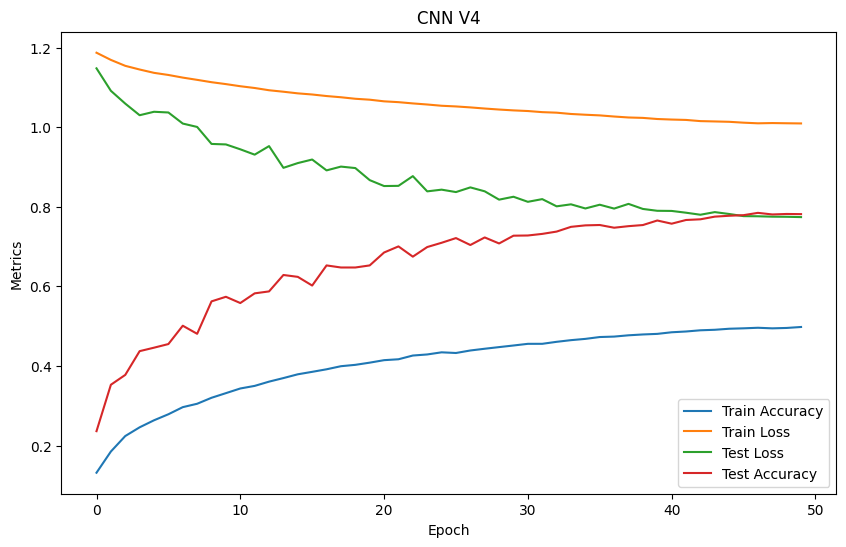

In [ ]:

plot_metrics(metrics_APL, title="CNN V4", save=None)
# plot_metrics(metrics_NFL)


### NCE + CE - APL

In [ ]:
# Define model, optimizer, loss function, and scheduler
# model_V5 = CNN_V3()  # Make sure this is correctly instantiated
# optimizer_V5 = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
# criterion_V5 = NormalizedFocalLoss()  # Ensure this matches the saved model
# scheduler_V5 = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Load the saved data
loaded = load_saved_data("APL\\Models\\cnn_5.pth", model_APL, optimizer_APL, criterion, scheduler_APL)

if loaded:
    model_APL, criterion, optimizer_APL, scheduler_APL, metrics_APL = loaded
    print("Model and parameters successfully restored!")
    print(metrics)
else:
    print("Failed to load model parameters.")


NameError: name 'model_APL' is not defined

In [ ]:
_,__,___,____ = [metrics_APL[i] for i in metrics_APL]
test = torch.cat([_,torch.zeros(1)])
test.shape, test[1+49]

(torch.Size([51]), tensor(0.))

In [ ]:
metrics_APL_NEW, train_time_APL_NEW = train_loop(
    model=model_APL,
    train_data_loader=train_data_loader,
    test_data_loader=test_data_loader,
    criterion=apl_loss_fn,
    optimizer=optimizer_APL,
    scheduler=scheduler_APL,
    loss_type="APL",
    num_epochs=50,
    INCLUDE_TEST=True,
    DEVICE=DEVICE,
    noise_rate=train_data_noise.noise_rate,
    continuation=True,
    old_metrics=metrics_APL,
    continuation_version=5
)

Criterion: APL
Noise Rate: 0.4
version=5


Resuming Training (New Session) with same model(version=5)... 




Resuming Training (New Session) with same model (version=5)... 


train_losses.shape=torch.Size([100])
Epoch 51/100 | Train Loss: 1.0167, Train Accuracy: 0.4898 | Test Loss: 0.7812, Test Accuracy: 0.7806 | 30.292 s
Epoch 52/100 | Train Loss: 1.0171, Train Accuracy: 0.4868 | Test Loss: 0.7816, Test Accuracy: 0.7737 | 61.303 s
Epoch 53/100 | Train Loss: 1.0171, Train Accuracy: 0.4869 | Test Loss: 0.7810, Test Accuracy: 0.7751 | 92.577 s
Epoch 54/100 | Train Loss: 1.0168, Train Accuracy: 0.4873 | Test Loss: 0.7837, Test Accuracy: 0.7735 | 123.746 s
Epoch 55/100 | Train Loss: 1.0175, Train Accuracy: 0.4854 | Test Loss: 0.7850, Test Accuracy: 0.7736 | 155.016 s
Epoch 56/100 | Train Loss: 1.0182, Train Accuracy: 0.4847 | Test Loss: 0.7850, Test Accuracy: 0.7702 | 186.064 s
Epoch 57/100 | Train Loss: 1.0190, Train Accuracy: 0.4848 | Test Loss: 0.7886, Test Accuracy: 0.7692 | 218.256 s

In [ ]:
# criterion_NCE, optimizer_NCE, scheduler_NCE, criterion_NFL, optimizer_NFL, scheduler_NFL

## **Paper Implementation**

In [110]:
model = CNN9Layer(num_classes=10).to(DEVICE)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,            # Learning rate used for CNNs
    momentum=0.9,
    weight_decay=5e-4
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=100          # Number of epochs
)

criterion = NormalizedCrossEntropyLoss()

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

trainset = NoisyDataset(root='./data', train=True, download=True, transform=transform_train, noise_rate=0.5)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=0)

Mask Info...
	Expected Noise Rate: 0.500 | Actual Noise Rate:  0.497 | True/False : 0.988


In [112]:
metrics_NEW, train_time_NEW = train_loop(
    model=model,
    train_data_loader=trainloader,
    test_data_loader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_type="NCE",
    num_epochs=100,
    INCLUDE_TEST=True,
    DEVICE=DEVICE,
    noise_rate=trainset.noise_rate,
    continuation=False,
    old_metrics=None,
    continuation_version=None
)

Criterion: NCE
Noise Rate: 0.5
version=26
train_losses.shape=torch.Size([100])
Epoch 1/100 | Train Loss: 0.9727, Train Accuracy: 0.2303 | Test Loss: 0.8708, Test Accuracy: 0.4637 | 26.467 s
Epoch 2/100 | Train Loss: 0.9680, Train Accuracy: 0.2490 | Test Loss: 0.8589, Test Accuracy: 0.5072 | 55.259 s
Epoch 3/100 | Train Loss: 0.9639, Train Accuracy: 0.2622 | Test Loss: 0.8511, Test Accuracy: 0.5396 | 82.180 s
Epoch 4/100 | Train Loss: 0.9613, Train Accuracy: 0.2713 | Test Loss: 0.8428, Test Accuracy: 0.5515 | 107.439 s
Epoch 5/100 | Train Loss: 0.9576, Train Accuracy: 0.2834 | Test Loss: 0.8366, Test Accuracy: 0.5789 | 132.910 s
Epoch 6/100 | Train Loss: 0.9559, Train Accuracy: 0.2910 | Test Loss: 0.8284, Test Accuracy: 0.5615 | 158.108 s
Epoch 7/100 | Train Loss: 0.9527, Train Accuracy: 0.2996 | Test Loss: 0.8290, Test Accuracy: 0.5822 | 184.698 s
Epoch 8/100 | Train Loss: 0.9521, Train Accuracy: 0.3037 | Test Loss: 0.8310, Test Accuracy: 0.6014 | 212.654 s
Epoch 9/100 | Train Loss: 0.

Scheduler state_dict not found. Loading default state.
Data loaded successfully from: CE\Models\cnn_0.pth


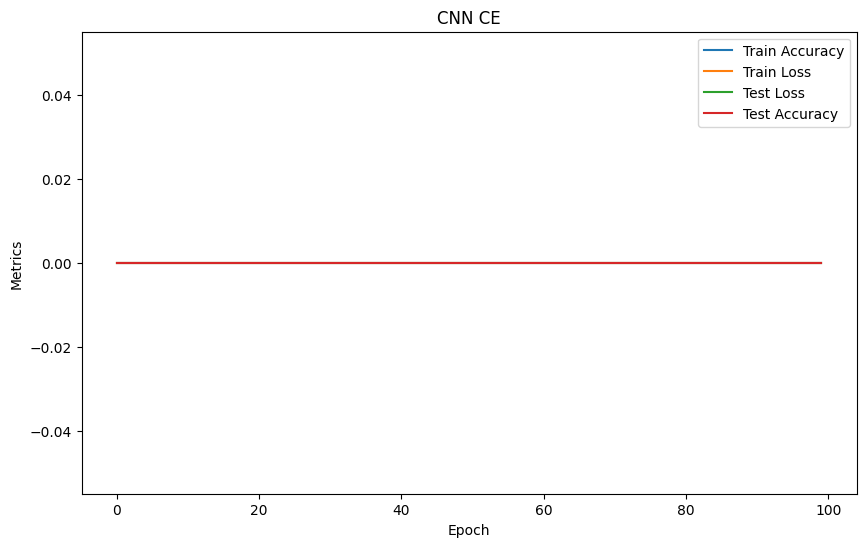

In [ ]:
model_CE, criterion_CE, optimizer_CE, scheduler_CE, metrics_CE = load_saved_data("CE\\Models\\cnn_0.pth", model, optimizer, criterion, scheduler)
plot_metrics_v2(metrics_CE, title="CNN CE", save=None)

In [ ]:
model_NCE, criterion_NCE, optimizer_NCE, scheduler_NCE, metrics_NCE = load_saved_data("NCE\\Models\\cnn_26.pth", model, optimizer, criterion, scheduler)
plot_metrics(metrics_NCE, title="CNN with NCE", save="CNN NCE.png")
metrics_NCE

Data loaded successfully from: NCE\Models\cnn_26.pth


{'Train Accuracy': tensor([0.2303, 0.2490, 0.2622, 0.2713, 0.2834, 0.2910, 0.2996, 0.3037, 0.3100,
         0.3154, 0.3193, 0.3245, 0.3268, 0.3318, 0.3346, 0.3377, 0.3436, 0.3427,
         0.3464, 0.3500, 0.3496, 0.3503, 0.3567, 0.3541, 0.3593, 0.3597, 0.3620,
         0.3626, 0.3649, 0.3654, 0.3672, 0.3703, 0.3703, 0.3713, 0.3733, 0.3734,
         0.3777, 0.3772, 0.3766, 0.3793, 0.3808, 0.3798, 0.3833, 0.3846, 0.3840,
         0.3886, 0.3868, 0.3882, 0.3894, 0.3910, 0.3928, 0.3923, 0.3920, 0.3962,
         0.3945, 0.3963, 0.3985, 0.3988, 0.3993, 0.4009, 0.4039, 0.4027, 0.4032,
         0.4037, 0.4055, 0.4061, 0.4073, 0.4084, 0.4091, 0.4107, 0.4098, 0.4120,
         0.4099, 0.4132, 0.4141, 0.4154, 0.4164, 0.4166, 0.4171, 0.4181, 0.4178,
         0.4179, 0.4204, 0.4220, 0.4203, 0.4226, 0.4214, 0.4223, 0.4224, 0.4229,
         0.4229, 0.4247, 0.4244, 0.4251, 0.4265, 0.4243, 0.4244, 0.4251, 0.4250,
         0.4280]),
 'Train Loss': tensor([0.9727, 0.9680, 0.9639, 0.9613, 0.9576, 0.9559, 0

In [ ]:
model_CE, criterion_CE, optimizer_CE, scheduler_CE, metrics_CE = load_saved_data("CE\\Models\\cnn_3.pth", model, optimizer, criterion, scheduler)
plot_metrics(metrics_CE, title="CNN with CE", save="CNN CE.png")
metrics_CE

Data loaded successfully from: NFL\Models\cnn_3.pth


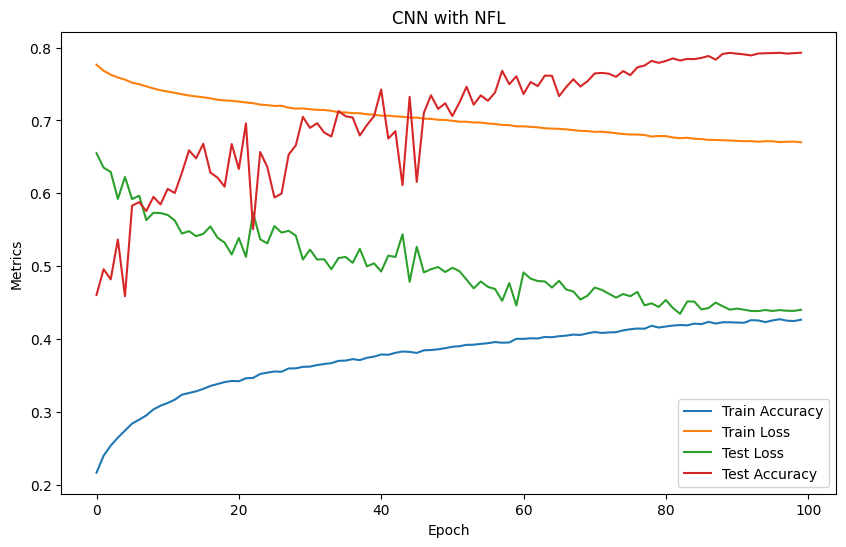

{'Train Accuracy': tensor([0.2167, 0.2400, 0.2539, 0.2648, 0.2744, 0.2841, 0.2895, 0.2953, 0.3035,
         0.3087, 0.3124, 0.3169, 0.3237, 0.3260, 0.3284, 0.3317, 0.3357, 0.3383,
         0.3410, 0.3426, 0.3422, 0.3463, 0.3467, 0.3522, 0.3540, 0.3556, 0.3552,
         0.3597, 0.3599, 0.3620, 0.3622, 0.3644, 0.3659, 0.3670, 0.3701, 0.3705,
         0.3725, 0.3712, 0.3743, 0.3760, 0.3789, 0.3785, 0.3812, 0.3830, 0.3825,
         0.3810, 0.3846, 0.3850, 0.3860, 0.3875, 0.3895, 0.3902, 0.3921, 0.3923,
         0.3935, 0.3944, 0.3959, 0.3950, 0.3954, 0.4004, 0.4003, 0.4011, 0.4008,
         0.4029, 0.4026, 0.4040, 0.4048, 0.4062, 0.4057, 0.4079, 0.4097, 0.4085,
         0.4092, 0.4095, 0.4120, 0.4135, 0.4145, 0.4142, 0.4183, 0.4159, 0.4173,
         0.4186, 0.4193, 0.4189, 0.4213, 0.4205, 0.4237, 0.4213, 0.4231, 0.4231,
         0.4227, 0.4224, 0.4260, 0.4255, 0.4233, 0.4256, 0.4273, 0.4253, 0.4248,
         0.4266]),
 'Train Loss': tensor([0.7764, 0.7682, 0.7628, 0.7589, 0.7560, 0.7518, 0

In [142]:
model_NFL, criterion_NFL, optimizer_NFL, scheduler_NFL, metrics_NFL = load_saved_data("NFL\\Models\\cnn_3.pth", model, optimizer, criterion, scheduler)
plot_metrics(metrics_NFL, title="CNN with NFL", save="CNN NFL.png")
metrics_NFL

In [ ]:
model_FL, criterion_FL, optimizer_FL, scheduler_FL, metrics_FL = load_saved_data("FL\\Models\\cnn_0.pth", model, optimizer, criterion, scheduler)
plot_metrics(metrics_FL, title="CNN with FL", save="CNN FL.png")
metrics_CE

In [ ]:
def merge_metrics(metrics_list, names):
    """
    Merge multiple metrics dictionaries into separate dictionaries for each metric type.
    
    Args:
        metrics_list: List of metrics dictionaries (m1, m2, ..., mn)
        names: List of names corresponding to each metrics dictionary (["l1", "l2", ..., "ln"])
        
    Returns:
        Dictionary containing merged metrics separated by type with names added
    """
    # Initialize merged dictionaries for each metric type
    merged = {
        "Test Loss": {},
        "Train Loss": {},
        "Train Accuracy": {},
        "Test Accuracy": {}
    }
    
    # Verify input lengths match
    if len(metrics_list) != len(names):
        raise ValueError("Length of metrics_list must match length of names")
    
    # Iterate through each metrics dictionary and corresponding name
    for metrics, name in zip(metrics_list, names):
        # Add each metric to the merged dictionary with the given name
        for metric_type in merged.keys():
            if metric_type in metrics:
                merged[metric_type][name] = metrics[metric_type]
            else:
                # Handle case where a metric type is missing (optional)
                merged[metric_type][name] = None  # or you could raise an error
    
    return merged

In [125]:
data = load_saved_data("NCE\\Models\\cnn_26.pth", model, optimizer, criterion, scheduler)

Data loaded successfully from: NCE\Models\cnn_26.pth


{'Train Accuracy': tensor([0.2303, 0.2490, 0.2622, 0.2713, 0.2834, 0.2910, 0.2996, 0.3037, 0.3100,
         0.3154, 0.3193, 0.3245, 0.3268, 0.3318, 0.3346, 0.3377, 0.3436, 0.3427,
         0.3464, 0.3500, 0.3496, 0.3503, 0.3567, 0.3541, 0.3593, 0.3597, 0.3620,
         0.3626, 0.3649, 0.3654, 0.3672, 0.3703, 0.3703, 0.3713, 0.3733, 0.3734,
         0.3777, 0.3772, 0.3766, 0.3793, 0.3808, 0.3798, 0.3833, 0.3846, 0.3840,
         0.3886, 0.3868, 0.3882, 0.3894, 0.3910, 0.3928, 0.3923, 0.3920, 0.3962,
         0.3945, 0.3963, 0.3985, 0.3988, 0.3993, 0.4009, 0.4039, 0.4027, 0.4032,
         0.4037, 0.4055, 0.4061, 0.4073, 0.4084, 0.4091, 0.4107, 0.4098, 0.4120,
         0.4099, 0.4132, 0.4141, 0.4154, 0.4164, 0.4166, 0.4171, 0.4181, 0.4178,
         0.4179, 0.4204, 0.4220, 0.4203, 0.4226, 0.4214, 0.4223, 0.4224, 0.4229,
         0.4229, 0.4247, 0.4244, 0.4251, 0.4265, 0.4243, 0.4244, 0.4251, 0.4250,
         0.4280]),
 'Train Loss': tensor([0.9727, 0.9680, 0.9639, 0.9613, 0.9576, 0.9559, 0